## Libraries

In [1]:
import os


import polars as pl
import pandas as pd
import missingno as msno

import seaborn as sn
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from astral import LocationInfo
from astral.sun import sun
from workalendar.europe import UnitedKingdom
from sklearn.preprocessing import LabelEncoder

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from lightgbm import LGBMRegressor

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

pd.set_option('display.max_columns', None)

## Parameters

In [2]:
currentFolder = os.getcwd()

dataFolder = os.path.join(currentFolder, 'data')

In [133]:
cal = UnitedKingdom()

location = LocationInfo(
    latitude=52.4803962,
    longitude=-1.9129882
)


## Functions

## Read files

In [4]:
filesList = [
    os.path.join(dataFolder, i) 
    for i in os.listdir(dataFolder) 
    if (i.endswith('.xls')) & (i.startswith('purchase-card-transactions-')) 
]

In [5]:
if 'concatedDF' in globals():
    del concatedDF

for filePath in filesList:
    fileReaded = pd.read_excel(filePath)
    fileReaded.columns = [i.upper().strip() for i in fileReaded.columns]
    fileReaded = fileReaded.rename(
        columns = {'DIRECTORATES': 'DIRECTORATE'},
        errors='ignore'
    )
    
    if isinstance(fileReaded, pd.DataFrame):
        if 'concatedDF' not in globals():
            concatedDF = fileReaded.copy()
        else:
            concatedDF = pd.concat(
                [
                    concatedDF,
                    fileReaded

                ],
                ignore_index = True
            )

    del fileReaded

### Analyze Missing Values

#### Data Types

In [6]:
concatedDF.dtypes

TRANS DATE                datetime64[ns]
TRANS TAX DESC                    object
ORIGINAL GROSS AMT               float64
ORIGINAL CUR                      object
BILLING GROSS AMT                float64
BILLING CUR CODE                  object
TRANS TAX RATE                   float64
TRANS TAX AMT                    float64
MERCHANT NAME                     object
CARD NUMBER                       object
TRANS CAC CODE 1                  object
TRANS CAC DESC 1                  object
TRANS CAC CODE 2                  object
TRANS CAC DESC 2                  object
TRANS CAC CODE 3                  object
DIRECTORATE                       object
TRANS ORIGINAL NET AMT           float64
TRANS CAC CODE 4                  object
TRANS CAC CODE 5                  object
TRANS CAC CODE 6                  object
TRANS CAC CODE 7                  object
TRANS CAC CODE 8                  object
MERCHANT TAX REG NO               object
MCC CODE                         float64
TRANS CAC DESC 3

CAC (Client Account Credit): The CAC transaction is used to post client payments and Credit Memos for fees and costs.  It is also used to apply client credits to Future Costs Funds. 

#### Missing Values Plot

<AxesSubplot: >

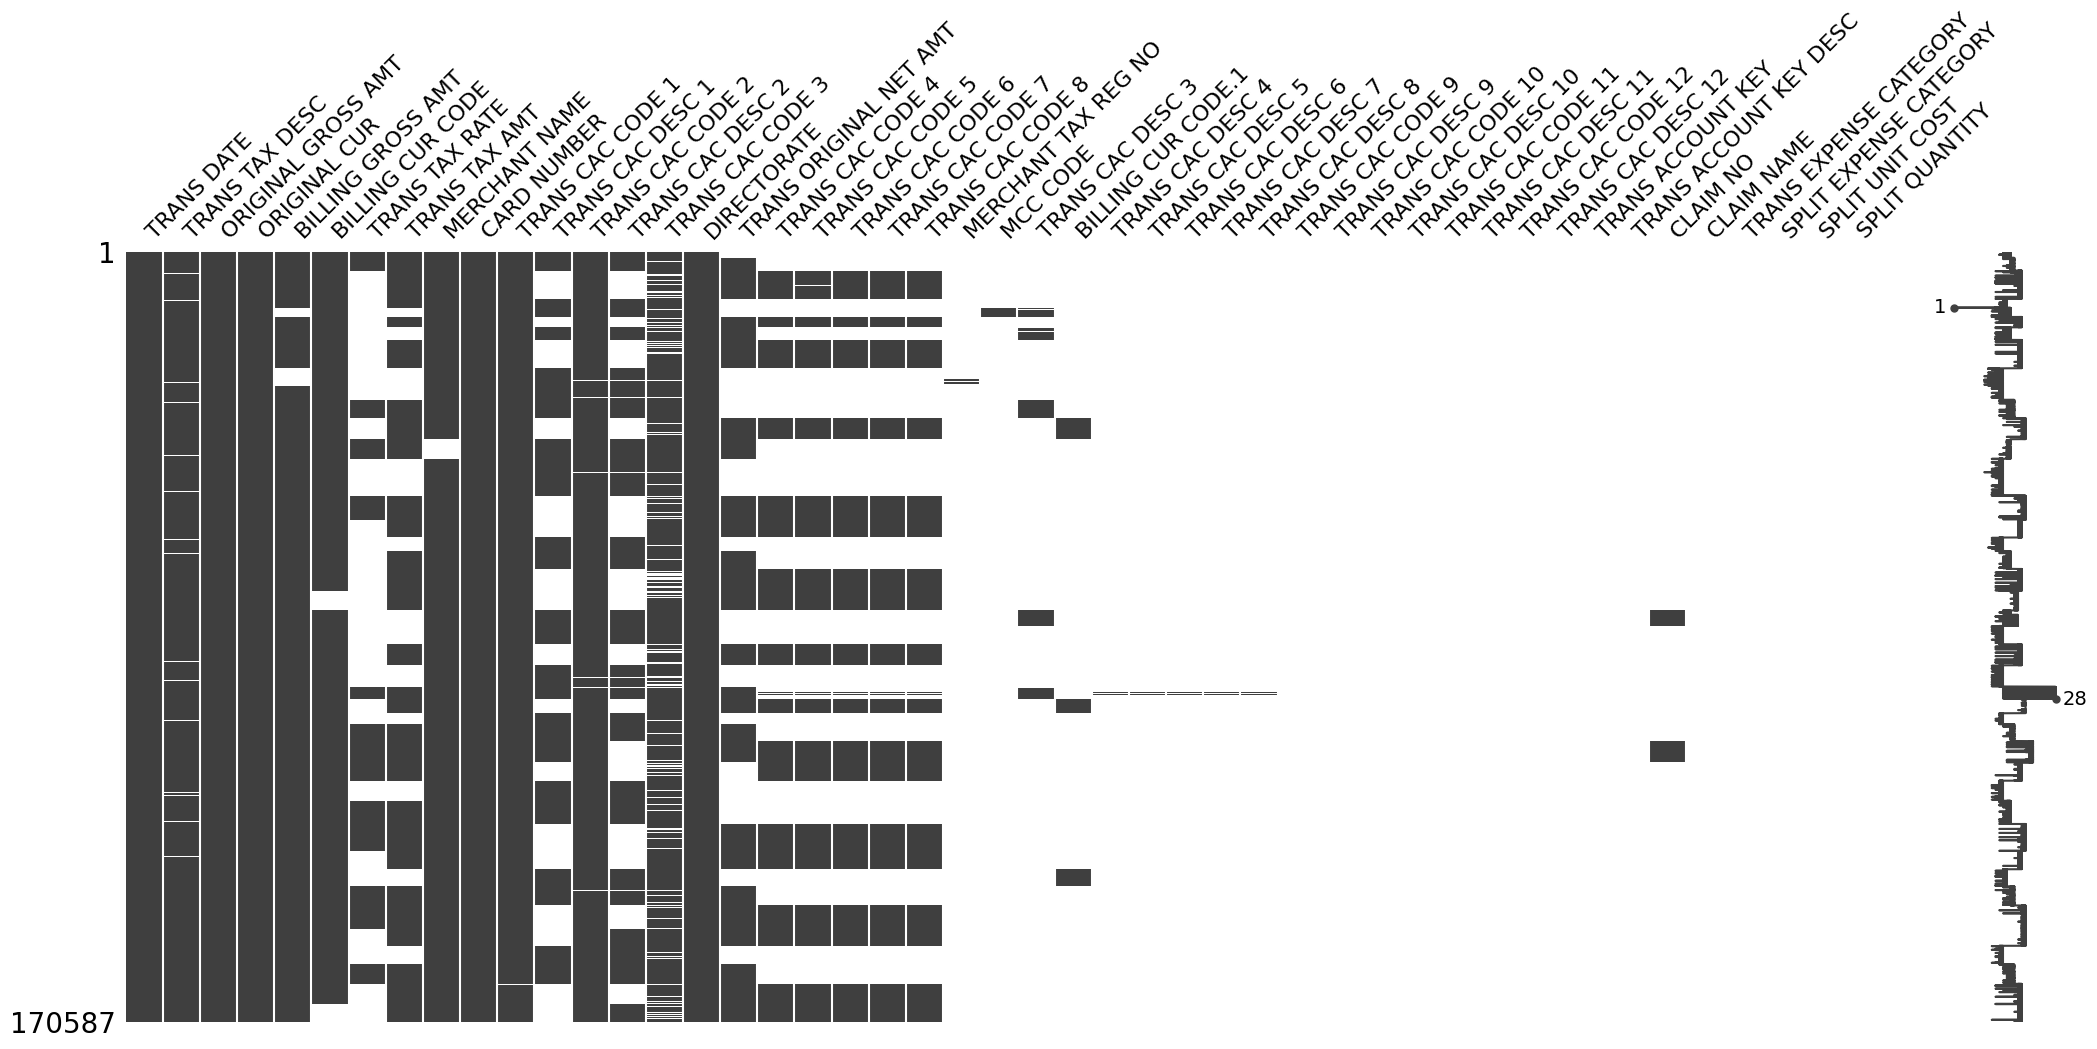

In [7]:
msno.matrix(concatedDF)

#### Drop Columns with no Data (not enough information)

In [7]:
concatedDF = concatedDF.drop(
    columns = [
        'CARD NUMBER','MERCHANT TAX REG NO', 'MCC CODE', 'BILLING CUR CODE.1', 
        'TRANS CAC DESC 3', 'TRANS CAC DESC 4', 'TRANS CAC DESC 5', 'TRANS CAC DESC 6',
        'TRANS CAC DESC 7', 'TRANS CAC DESC 8', 'TRANS CAC CODE 9',
        'TRANS CAC DESC 9', 'TRANS CAC CODE 10', 'TRANS CAC DESC 10',
        'TRANS CAC CODE 11', 'TRANS CAC DESC 11', 'TRANS CAC CODE 12',
        'TRANS CAC DESC 12', 'TRANS ACCOUNT KEY', 'TRANS ACCOUNT KEY DESC',
        'CLAIM NO', 'CLAIM NAME', 'TRANS EXPENSE CATEGORY',
        'SPLIT EXPENSE CATEGORY', 'SPLIT UNIT COST', 'SPLIT QUANTITY'
    ]
)

#### For the Rest of the Columns

##### Missing Values

<AxesSubplot: >

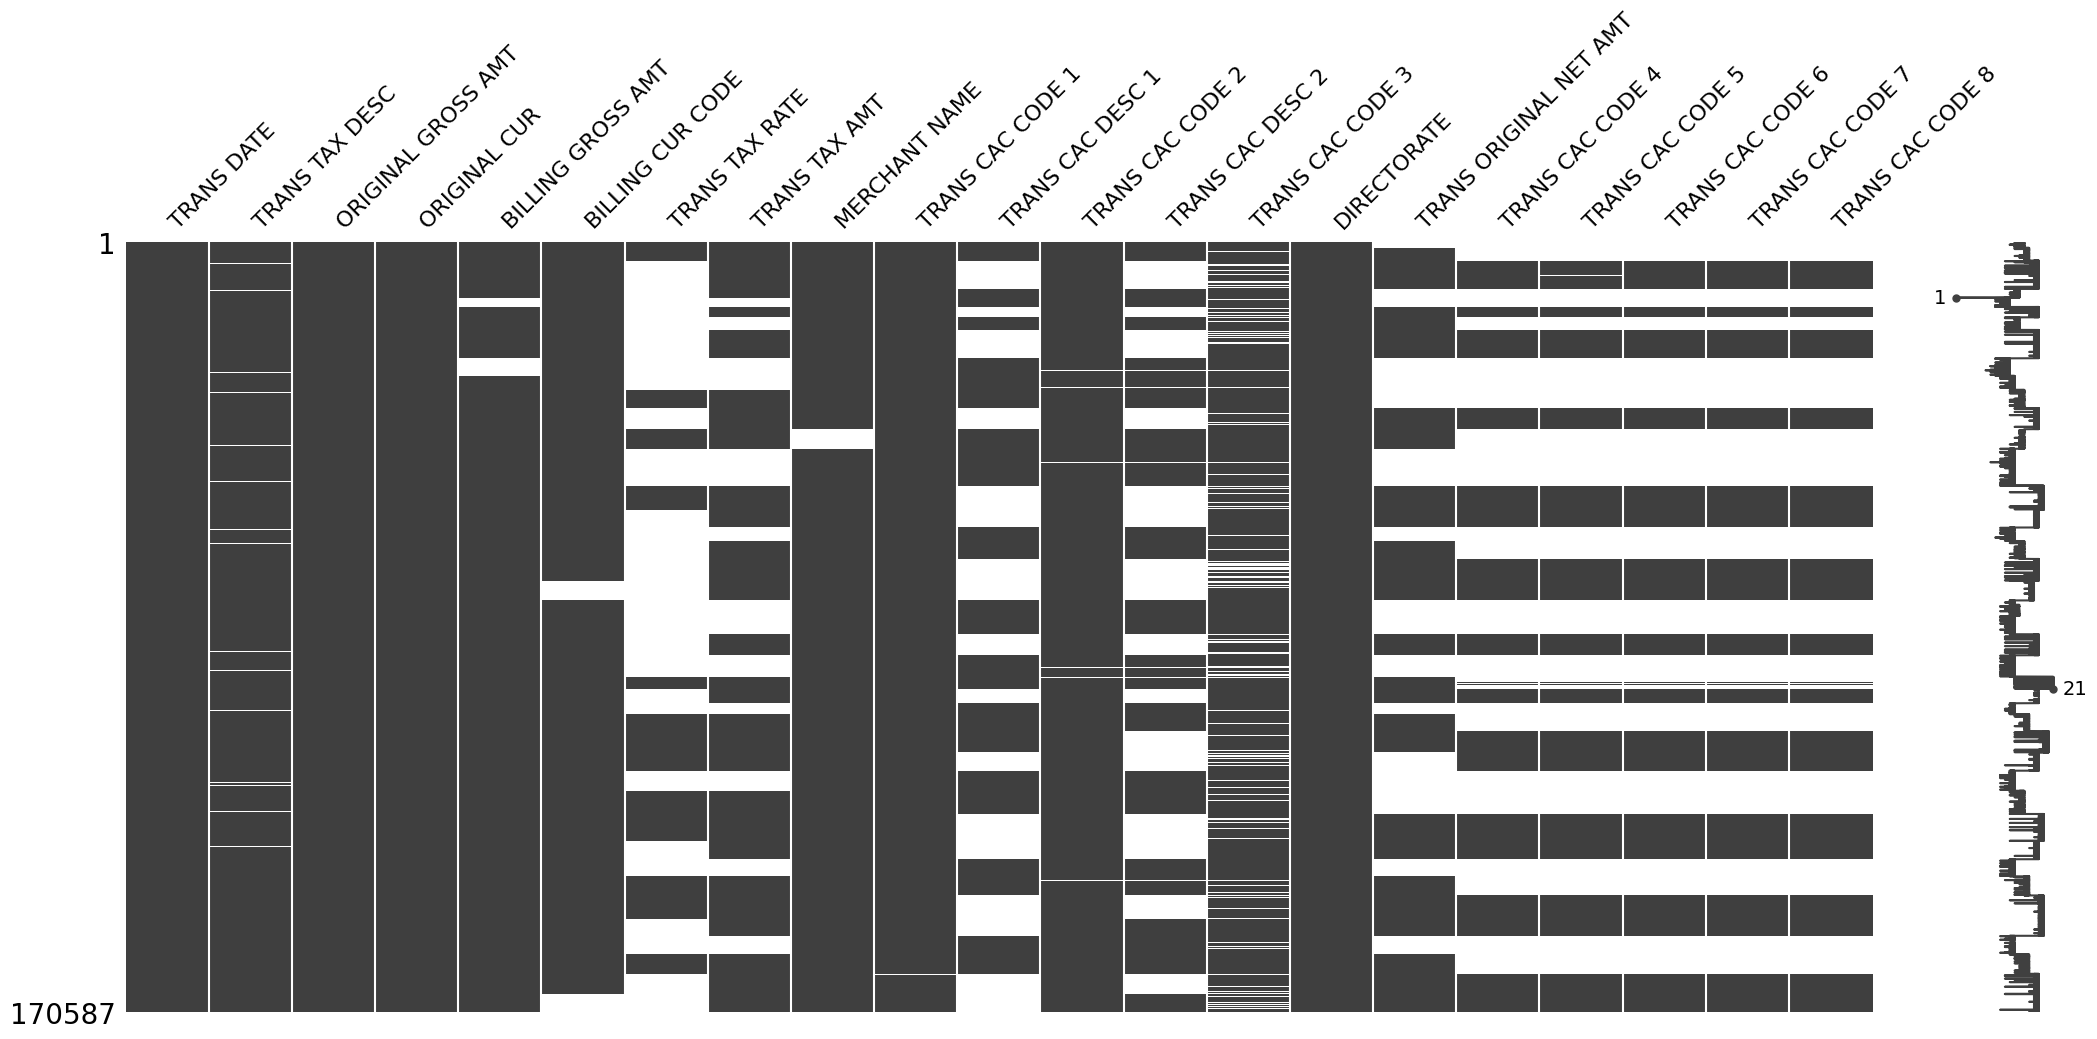

In [8]:
msno.matrix(concatedDF)

#### Missing values Correlation

In [47]:
# concatedDF[['TRANS TAX RATE', 'TRANS TAX DESC']].value_counts()

<AxesSubplot: >

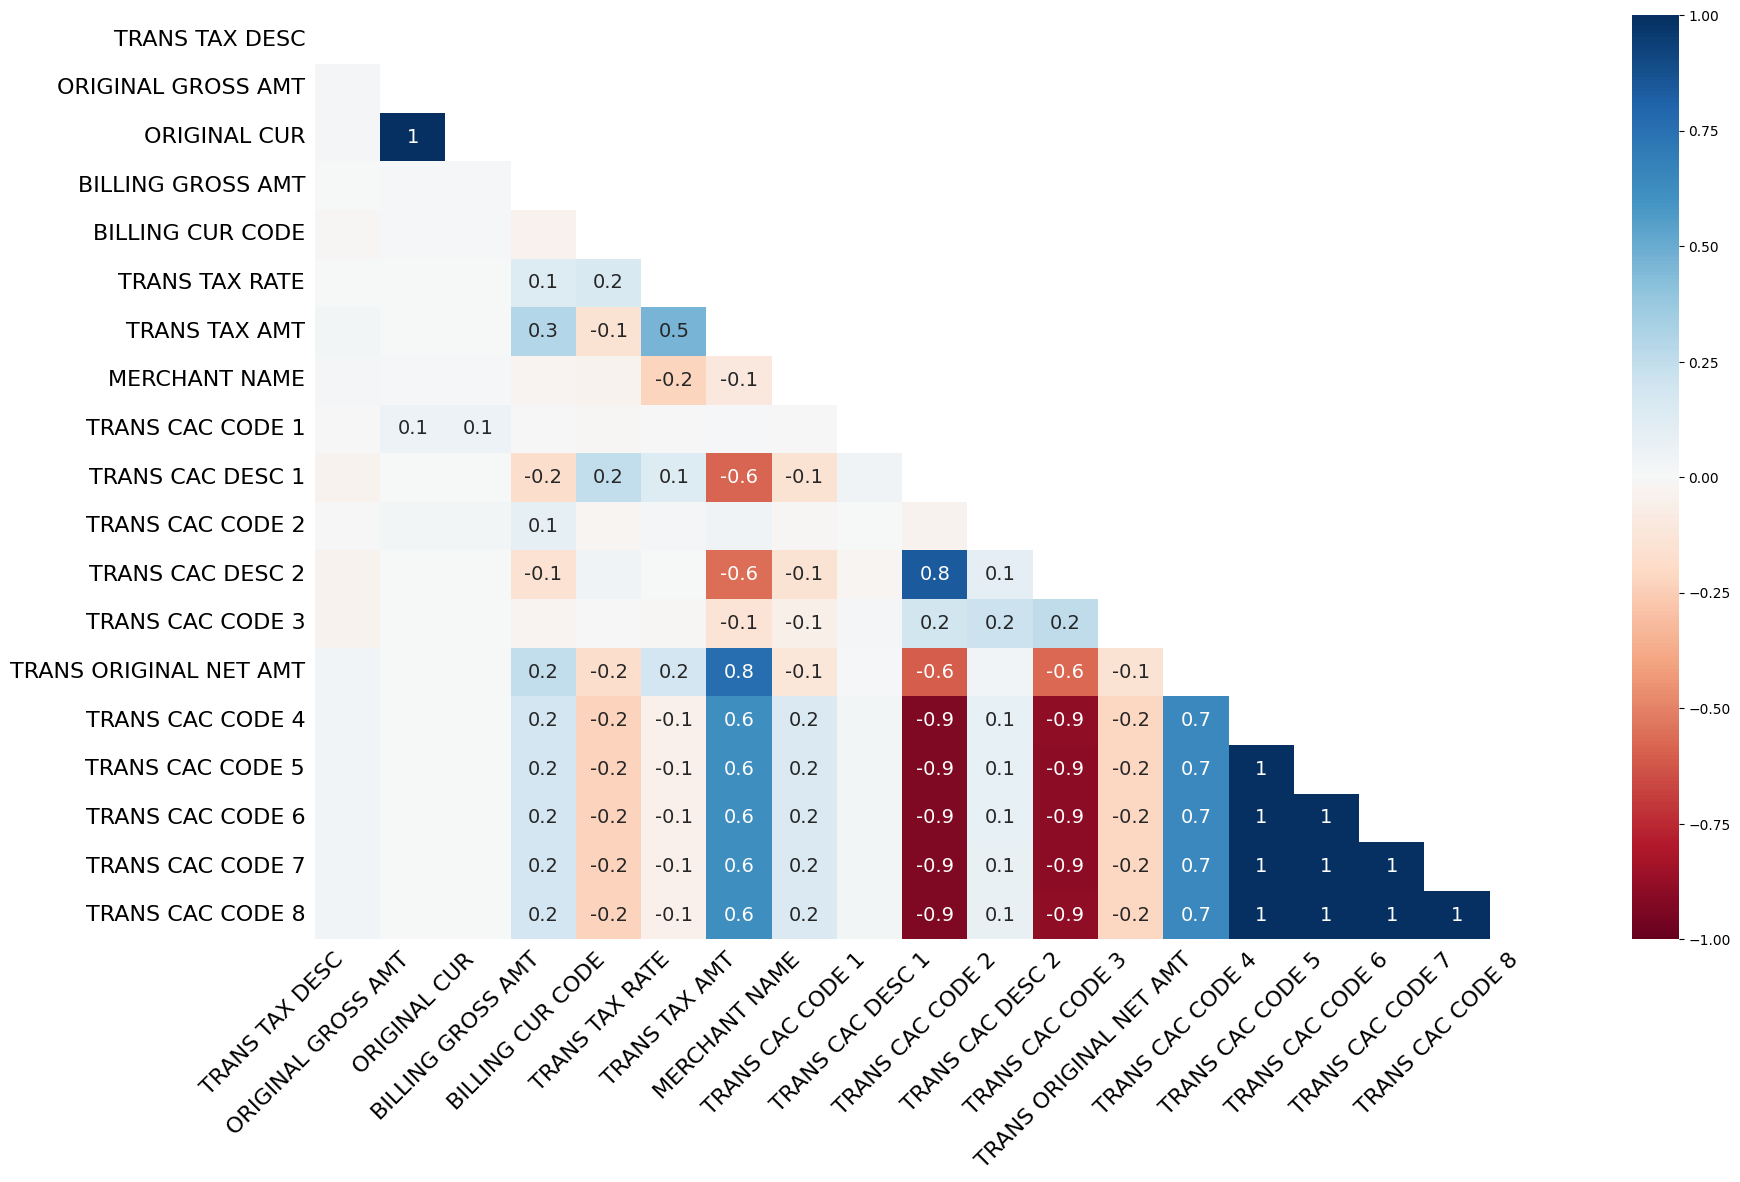

In [9]:
msno.heatmap(
    concatedDF[
        [
            'TRANS TAX DESC', 'ORIGINAL GROSS AMT', 'ORIGINAL CUR',
            'BILLING GROSS AMT', 'BILLING CUR CODE', 'TRANS TAX RATE',
            'TRANS TAX AMT', 'MERCHANT NAME', 'TRANS CAC CODE 1',
            'TRANS CAC DESC 1', 'TRANS CAC CODE 2', 'TRANS CAC DESC 2',
            'TRANS CAC CODE 3', 'DIRECTORATE', 'TRANS ORIGINAL NET AMT',
            'TRANS CAC CODE 4', 'TRANS CAC CODE 5', 'TRANS CAC CODE 6',
            'TRANS CAC CODE 7', 'TRANS CAC CODE 8'
        ]
    ]
)

#### Numerical Correlation

In [10]:
concatedDF[['ORIGINAL GROSS AMT',
    'BILLING GROSS AMT', 'TRANS TAX RATE','TRANS TAX AMT']].dropna().corr()

,ORIGINAL GROSS AMT,BILLING GROSS AMT,TRANS TAX RATE,TRANS TAX AMT
ORIGINAL GROSS AMT,1.000000,0.194927,-0.015570,0.075356
BILLING GROSS AMT,0.194927,1.000000,-0.007270,0.420288
TRANS TAX RATE,-0.015570,-0.007270,1.000000,0.163177
TRANS TAX AMT,0.075356,0.420288,0.163177,1.000000


#### Categorical Values Counts

In [11]:
catCols = [
    'TRANS TAX DESC','ORIGINAL CUR','BILLING CUR CODE','MERCHANT NAME',
    'DIRECTORATE','TRANS CAC CODE 1','TRANS CAC DESC 1',
    'TRANS CAC CODE 2','TRANS CAC DESC 2','TRANS CAC CODE 3','TRANS CAC CODE 4',
    'TRANS CAC CODE 5','TRANS CAC CODE 6','TRANS CAC CODE 7','TRANS CAC CODE 8'
]

In [12]:
for col in catCols:
    
    counts = pd.concat(
        [
            concatedDF[col].value_counts(dropna = False, normalize = False),
            concatedDF[col].value_counts(dropna = False, normalize = True),
        ],
        axis=1
    )
    
    counts.columns = ['count', 'proportion']

    counts = counts.assign(
        proportion = lambda x: x['proportion'] * 100
    ).reset_index(
        drop = False
    )
    
    counts = counts.loc[0:10]
    
    counts = counts.rename(
        columns = {'index' : col}
    ).set_index(
        [col]
    )
    
    counts = counts.style.format(
        {'proportion': "{:,.2f}%",'count': "{:,.0f}"}
    )
    
    display(counts)

,count,proportion
TRANS TAX DESC,,
VR,"106,171",62.24%
VZ,"58,320",34.19%
VL,"2,944",1.73%
nan,"2,541",1.49%
0 Percent,337,0.20%
VE,131,0.08%
VF,107,0.06%
VT,22,0.01%
VS,8,0.00%


,count,proportion
ORIGINAL CUR,,
GBP,"169,571",99.40%
USD,644,0.38%
EUR,330,0.19%
PKR,11,0.01%
PLN,6,0.00%
AUD,5,0.00%
HUF,3,0.00%
CAD,3,0.00%
BRL,3,0.00%


,count,proportion
BILLING CUR CODE,,
GBP,"162,310",95.15%
nan,"8,277",4.85%


,count,proportion
MERCHANT NAME,,
amznmktplace,"32,994",19.34%
nan,"4,333",2.54%
asda groceries online,"3,492",2.05%
parking 1vr,"2,882",1.69%
amznmktplace amazon.co.uk,"2,668",1.56%
post office counter,"2,307",1.35%
bcc clean air zone,"2,297",1.35%
tesco pay at pump 4231,"2,132",1.25%
applegreen kingstanding,"1,705",1.00%


,count,proportion
DIRECTORATE,,
SCHOOLS,"98,672",57.84%
NEIGHBOURHOODS,"32,869",19.27%
INCLUSIVE GROWTH,"6,609",3.87%
EDUCATION & SKILLS,"6,467",3.79%
CITY OPERATIONS,"6,105",3.58%
ADULT SOCIAL CARE,"5,539",3.25%
FINANCE AND GOVERNANCE,"5,468",3.21%
Digital & Customer Services,"2,362",1.38%
CITY HOUSING,"1,672",0.98%


,count,proportion
TRANS CAC CODE 1,,
B1,"81,446",47.74%
L100,"25,343",14.86%
K020,"10,302",6.04%
L220,"6,527",3.83%
L080,"5,187",3.04%
MC70,"4,357",2.55%
H0R0,"3,041",1.78%
L030,"2,687",1.58%
L120,"2,359",1.38%


,count,proportion
TRANS CAC DESC 1,,
nan,"77,501",45.43%
Equip Operational,"25,343",14.86%
Vehicle Fuel,"10,302",6.04%
Purchases Food,"6,527",3.83%
Birmingham City Council,"5,404",3.17%
Mat'l Raw/Drct,"5,187",3.04%
Supplies & Sev Mic,"4,357",2.55%
Conference Fees Subs UK,"3,041",1.78%
Books,"2,687",1.58%


,count,proportion
TRANS CAC CODE 2,,
RUF0F,"5,434",3.19%
AV02B,"4,495",2.64%
AV01C,"4,051",2.37%
REAAB,"3,944",2.31%
AV01F,"3,341",1.96%
AX073,"3,054",1.79%
AV09H,"2,893",1.70%
AV0AR,"2,088",1.22%
AX014,"1,545",0.91%


,count,proportion
TRANS CAC DESC 2,,
nan,"75,356",44.17%
Illegal Money Lending T Stds Comm Inv.,"5,434",3.19%
The City of Birmingham School,"4,251",2.49%
Dame Ellen Pinsent,"1,500",0.88%
Castle Vale Nursery,"1,453",0.85%
Transport User Admin,"1,377",0.81%
Baskerville,"1,286",0.75%
Technical Unit,"1,187",0.70%
West Heath Primary,"1,052",0.62%


,count,proportion
TRANS CAC CODE 3,,
A00,"82,837",48.56%
nan,"21,976",12.88%
4A0A,"8,923",5.23%
4P00,"8,348",4.89%
3A01,"7,447",4.37%
4A01,"7,428",4.35%
4B00,"5,906",3.46%
3D01,"2,989",1.75%
4A04,"2,067",1.21%


,count,proportion
TRANS CAC CODE 4,,
nan,"88,354",51.79%
ED1,"44,201",25.91%
E00,"33,466",19.62%
EH1,"2,948",1.73%
N01,"1,307",0.77%
E01,77,0.05%
EHE,26,0.02%
EHD,18,0.01%
EZ0,17,0.01%


,count,proportion
TRANS CAC CODE 5,,
nan,"88,402",51.82%
JZZZZZ,"80,194",47.01%
EZZZZZ,"1,324",0.78%
JV005Y,422,0.25%
JV0038,96,0.06%
JV003K,31,0.02%
JV00DD,20,0.01%
L00116,13,0.01%
JV00DM,13,0.01%


,count,proportion
TRANS CAC CODE 6,,
nan,"88,409",51.83%
TV1L0,"44,286",25.96%
TZZZZ,"5,511",3.23%
TV5NQ,"5,321",3.12%
TV31E,"2,759",1.62%
TV2UQ,"2,321",1.36%
QZZZZ,"1,307",0.77%
TV39V,888,0.52%
TV5F6,663,0.39%


,count,proportion
TRANS CAC CODE 7,,
nan,"88,398",51.82%
JZZZ,"80,882",47.41%
UZZZ,"1,307",0.77%


,count,proportion
TRANS CAC CODE 8,,
nan,"88,410",51.83%
JXXX,"80,870",47.41%
UXXX,"1,307",0.77%


#### Drop Columns with no Data (not enough information OR irrelevant)

In [13]:
dropCols = ['ORIGINAL CUR', 'BILLING CUR CODE', 'TRANS CAC CODE 7', 'TRANS CAC CODE 8']

concatedDF = concatedDF.drop(columns = dropCols)

catCols = list(set(catCols) - set(dropCols))

## 1. Unsual Transactions

Using number of transactions according to time windows 

In [14]:
timeWindows = 1 ## days
anomalyPercentil = 0.05

In [15]:
plotInterval = "(dailyTrans.index >= '2022-01-01') & (dailyTrans.index <= '2022-12-31')"

### By Num of Transactions

In [16]:
dailyTrans = concatedDF['TRANS DATE'].value_counts()
dailyTrans = dailyTrans.sort_index()
dailyTrans = dailyTrans.to_frame()
dailyTrans = dailyTrans.reset_index(drop = False)
dailyTrans = dailyTrans.rename(
    columns = {'TRANS DATE' : 'count', 'index':'TRANS DATE'}
)
dailyTrans = dailyTrans.set_index('TRANS DATE')

dailyTrans = dailyTrans.resample('{}D'.format(timeWindows)).sum()


dailyTrans['BUSSINES DAY'] = [cal.is_working_day(i) for i in dailyTrans.index.tolist()]

<AxesSubplot: xlabel='TRANS DATE'>

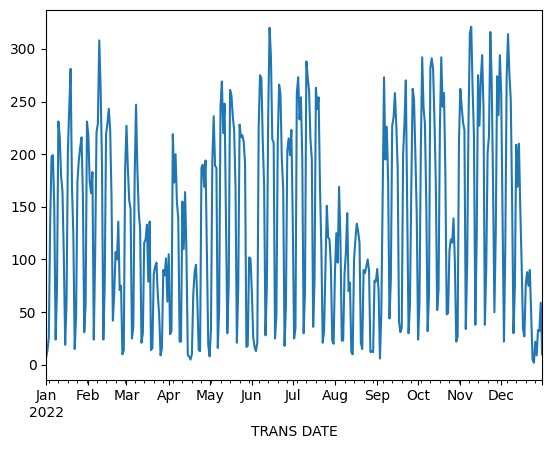

In [17]:
dailyTrans[eval(plotInterval)]['count'].plot()

#### Analysis by Bussines Day - Year

##### Bussines Day

In [18]:
grouped = dailyTrans[['BUSSINES DAY', 'count']].groupby(
    ['BUSSINES DAY']
).agg(
    ['min', 'max', 'mean', 'median']
)

grouped.columns = [i[1] for i in grouped.columns]

grouped.style.format(
    {'min': "{:,.0f}",'max': "{:,.0f}",'mean': "{:,.2f}",'median': "{:,.2f}"}
)

,min,max,mean,median
BUSSINES DAY,,,,
False,0,126,29.88,25.00
True,0,321,149.69,158.50


##### Year - Bussines Day 

In [19]:
grouped = dailyTrans[['BUSSINES DAY', 'count']].assign(
    YEAR = lambda x: x.index.year
).groupby(
    ['YEAR', 'BUSSINES DAY']
).agg(
    ['min', 'max', 'mean', 'median']
)
grouped.columns = [i[1] for i in grouped.columns]

grouped.style.format(
    {'min': "{:,.0f}",'max': "{:,.0f}",'mean': "{:,.2f}",'median': "{:,.2f}"}
)

#### Applying Rules

In [20]:
dailyTrans['UNUSUAL'] = 'NO'


dailyTrans.loc[
    (
        dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['count'] > dailyTrans[dailyTrans['BUSSINES DAY']]['count'].quantile(1 - anomalyPercentil)
    ),
    'UNUSUAL'
] = 'UP'


dailyTrans.loc[
    (
        dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['count'] < dailyTrans[dailyTrans['BUSSINES DAY']]['count'].quantile(anomalyPercentil)
    ),
    'UNUSUAL'
] = 'DOWN'




dailyTrans.loc[
    (
        ~dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['count'] > dailyTrans[~dailyTrans['BUSSINES DAY']]['count'].quantile(1 - anomalyPercentil)
    ),
    'UNUSUAL'
] = 'UP'


dailyTrans.loc[
    (
        ~dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['count'] < dailyTrans[~dailyTrans['BUSSINES DAY']]['count'].quantile(anomalyPercentil)
    ),
    'UNUSUAL'
] = 'DOWN'

In [21]:
dailyTrans['COLOR'] = 'rgb(55, 83, 109)'
dailyTrans.loc[dailyTrans['UNUSUAL'] != 'NO', 'COLOR'] = 'red'

#### Result

In [22]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=dailyTrans[eval(plotInterval)].index,
        y=dailyTrans[eval(plotInterval)]['count'],
        marker_color=dailyTrans[eval(plotInterval)]['COLOR']
    )
)

fig.update_layout(
    template = 'plotly_white',
    title = 'Result of Applied Rules'
)

fig.show()

The rules are working well for the large number of transactions, but needs to improve in terms of small numbers (​is not visually perceptible).

No transactions in a day is also a anomaly!

#### Add Unsual Transactions to Original Dataset

In [23]:
concatedDF = concatedDF.merge(
    dailyTrans.reset_index(drop = False)[['TRANS DATE', 'UNUSUAL']].rename(columns = {'UNUSUAL': 'NUM UNUSUAL'}),
    how = 'outer'
)

In [24]:
del dailyTrans

### By Sum of Transactions Gross Amount 

In [25]:
dailyTrans = concatedDF[['TRANS DATE','ORIGINAL GROSS AMT']].groupby(by = ['TRANS DATE']).sum()
dailyTrans = dailyTrans.sort_index()

dailyTrans = dailyTrans.resample('{}D'.format(timeWindows)).sum()


dailyTrans['BUSSINES DAY'] = [cal.is_working_day(i) for i in dailyTrans.index.tolist()]

<AxesSubplot: xlabel='TRANS DATE'>

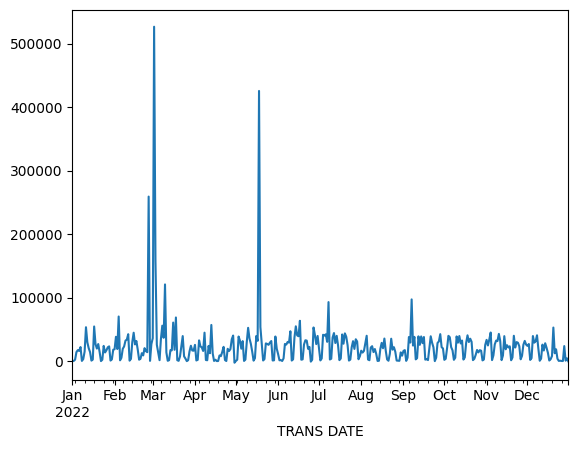

In [26]:
dailyTrans[eval(plotInterval)]['ORIGINAL GROSS AMT'].plot()

#### Analysis by Bussines Day - Year

##### Bussines Day

In [27]:
grouped = dailyTrans[['BUSSINES DAY', 'ORIGINAL GROSS AMT']].groupby(
    ['BUSSINES DAY']
).agg(
    ['min', 'max', 'mean', 'median']
)

grouped.columns = [i[1] for i in grouped.columns]

grouped.style.format(
    {'min': "{:,.0f}",'max': "{:,.0f}",'mean': "{:,.2f}",'median': "{:,.2f}"}
)

,min,max,mean,median
BUSSINES DAY,,,,
False,"-2,318","259,429","2,338.46","1,393.23"
True,-81,"527,074","21,128.88","17,506.84"


##### Year - Bussines Day 

In [28]:
grouped = dailyTrans[['BUSSINES DAY', 'ORIGINAL GROSS AMT']].assign(
    YEAR = lambda x: x.index.year
).groupby(
    ['YEAR', 'BUSSINES DAY']
).agg(
    ['min', 'max', 'mean', 'median']
)
grouped.columns = [i[1] for i in grouped.columns]

grouped.style.format(
    {'min': "{:,.0f}",'max': "{:,.0f}",'mean': "{:,.2f}",'median': "{:,.2f}"}
)

#### Applying Rules

In [29]:
dailyTrans['UNUSUAL'] = 'NO'


dailyTrans.loc[
    (
        dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['ORIGINAL GROSS AMT'] > dailyTrans[dailyTrans['BUSSINES DAY']]['ORIGINAL GROSS AMT'].quantile(1 - anomalyPercentil)
    ),
    'UNUSUAL'
] = 'UP'


dailyTrans.loc[
    (
        dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['ORIGINAL GROSS AMT'] < dailyTrans[dailyTrans['BUSSINES DAY']]['ORIGINAL GROSS AMT'].quantile(anomalyPercentil)
    ),
    'UNUSUAL'
] = 'DOWN'




dailyTrans.loc[
    (
        ~dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['ORIGINAL GROSS AMT'] > dailyTrans[~dailyTrans['BUSSINES DAY']]['ORIGINAL GROSS AMT'].quantile(1 - anomalyPercentil)
    ),
    'UNUSUAL'
] = 'UP'


dailyTrans.loc[
    (
        ~dailyTrans['BUSSINES DAY']
    ) & (
        dailyTrans['ORIGINAL GROSS AMT'] < dailyTrans[~dailyTrans['BUSSINES DAY']]['ORIGINAL GROSS AMT'].quantile(anomalyPercentil)
    ),
    'UNUSUAL'
] = 'DOWN'

In [30]:
dailyTrans['COLOR'] = 'rgb(55, 83, 109)'
dailyTrans.loc[dailyTrans['UNUSUAL'] != 'NO', 'COLOR'] = 'red'

#### Result

In [31]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=dailyTrans[eval(plotInterval)].index,
        y=dailyTrans[eval(plotInterval)]['ORIGINAL GROSS AMT'],
        marker_color=dailyTrans[eval(plotInterval)]['COLOR']
    )
)

fig.update_layout(
    template = 'plotly_white',
    title = 'Result of Applied Rules'
)

fig.show()

The rules are working well for the large gross amount, but needs to improve in terms of small (​is not visually perceptible).

No charges in a day is also a anomaly!

#### Add Unsual Transactions to Original Dataset

In [32]:
concatedDF = concatedDF.merge(
    dailyTrans.reset_index(drop = False)[['TRANS DATE', 'UNUSUAL']].rename(columns = {'UNUSUAL': 'AMT UNUSUAL'}),
    how = 'outer'
)

In [33]:
del dailyTrans

## 2. Forecast

Let's try a simple forecast for the 'ORIGINAL GROSS AMT'.

For this exercise, the time windows is 1 day (the same)

It is not simple add the rest of variables because of the lack of time in the 'TRANS DATE' variable

### Group the Data

In [134]:
data = concatedDF[
    (concatedDF['TRANS DATE'] >= '2023-01-01')
].dropna(
    subset = ['TRANS DATE', 'ORIGINAL GROSS AMT'], 
    how = 'any'
).drop(columns = ['NUM UNUSUAL', 'AMT UNUSUAL'])

data = data[['TRANS DATE', 'ORIGINAL GROSS AMT']].groupby(by = ['TRANS DATE']).sum()
data = data.reset_index(drop = False)
data = data.set_index('TRANS DATE')
data = data.asfreq('D')


data['MONTH'] = [int(i.month) for i in data.index]
data['DAY OF WEEK'] = [int(i.day_of_week + 1) for i in data.index]
data['HOLIDAY'] = [int(cal.is_holiday(i)) for i in data.index]
 

data['SUNRISE HOUR'] = [
    sun(location.observer, date=i, tzinfo=location.timezone)['sunrise'].hour
    for i in data.index
]
data['SUNSET HOUR'] = [
    sun(location.observer, date=i, tzinfo=location.timezone)['sunset'].hour
    for i in data.index
]
data['DAYLIGHT HOURS'] = (
    data['SUNSET HOUR'] - data['SUNRISE HOUR'] 
)

data = data.fillna(0)

<AxesSubplot: xlabel='TRANS DATE'>

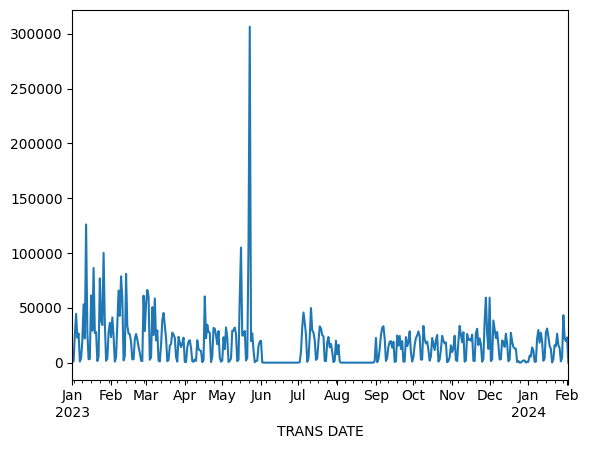

In [135]:
data['ORIGINAL GROSS AMT'].plot()

### Check Seasonality

Text(0.5, 1.0, 'ORIGINAL GROSS AMT by WEEK DAY')

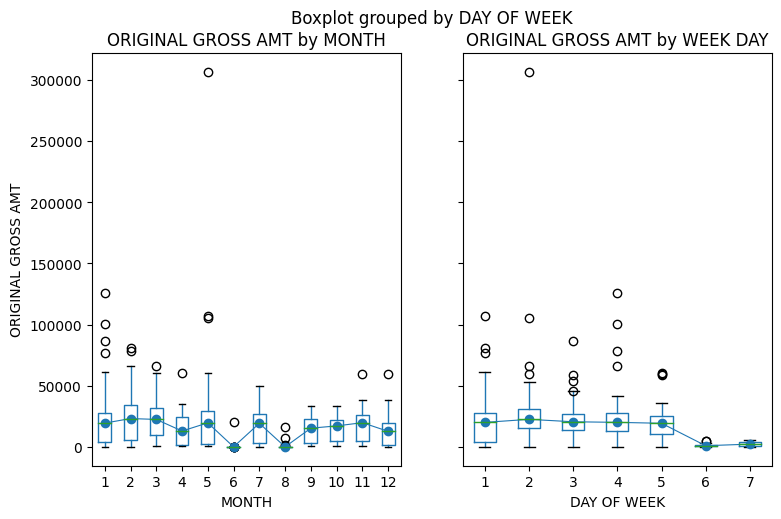

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 5.5), sharex=False, sharey=True)
axs = axs.ravel()


data.boxplot(column='ORIGINAL GROSS AMT', by='MONTH', ax=axs[0])
data.groupby('MONTH')['ORIGINAL GROSS AMT'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('ORIGINAL GROSS AMT')
axs[0].set_title('ORIGINAL GROSS AMT by MONTH')


data.boxplot(column='ORIGINAL GROSS AMT', by='DAY OF WEEK', ax=axs[1])
data.groupby('DAY OF WEEK')['ORIGINAL GROSS AMT'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('ORIGINAL GROSS AMT')
axs[1].set_title('ORIGINAL GROSS AMT by WEEK DAY')

As seen above, there is a clear difference in the number and value of transactions on weekdays vs holidays.

### ACF & PACF

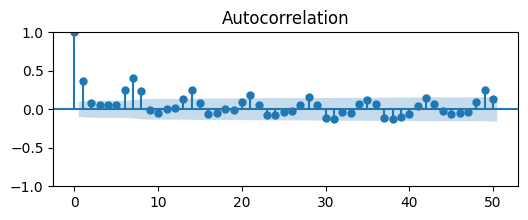

In [137]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(data['ORIGINAL GROSS AMT'], ax=ax, lags=50)
plt.show()

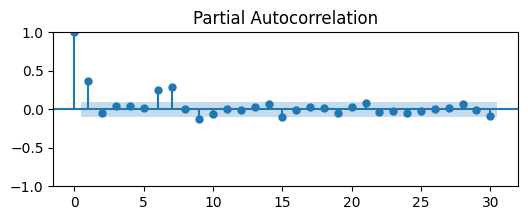

In [138]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(data['ORIGINAL GROSS AMT'], ax=ax, lags=30, method='ywm')
plt.show()

### Split in Train, Validataion, Test

In [139]:
lastTrain = '2023-10-31'
lastValidation = '2023-12-31'
dataTrain = data.loc[: lastTrain]
dataVal = data.loc[lastTrain:lastValidation]
dataTest = data.loc[lastValidation:]

print(f"Dates train : {dataTrain.index.min()} --- {dataTrain.index.max()}  (n={len(dataTrain)})")
print(f"Dates validacion : {dataVal.index.min()} --- {dataVal.index.max()}  (n={len(dataVal)})")
print(f"Dates test : {dataTest.index.min()} --- {dataTest.index.max()}  (n={len(dataTest)})")

Dates train : 2023-01-01 00:00:00 --- 2023-10-31 00:00:00  (n=304)
Dates validacion : 2023-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=62)
Dates test : 2023-12-31 00:00:00 --- 2024-02-02 00:00:00  (n=34)


### Fit Model

#### Baseline Forecast (Seasonal Naive Forecasting)

In [140]:
forecaster = ForecasterEquivalentDate(
   offset = 7,
   n_offsets = 1
)

# Train forecaster
# ==============================================================================
forecaster.fit(y=data[:lastValidation]['ORIGINAL GROSS AMT'])
forecaster

ForecasterEquivalentDate 
Offset: 7 
Number of offsets: 1 
Aggregation function: mean 
Window size: 7 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Creation date: 2024-02-21 10:09:46 
Last fit date: 2024-02-21 10:09:46 
Skforecast version: 0.11.0 
Python version: 3.8.0 
Forecaster id: None 

In [141]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['ORIGINAL GROSS AMT'],
    steps              = 7,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data[:lastValidation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print("Backtest error (MAE): {metric}".format(metric = metric))

  0%|          | 0/5 [00:00<?, ?it/s]

Backtest error (MAE): 7447.471515151515


In [142]:
fig = go.Figure()
trace1 = go.Scatter(x=dataTest.index, y=dataTest['ORIGINAL GROSS AMT'], name="Test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    template = 'plotly_white',
    title="Real vs Predicted in Test",
    xaxis_title="Date",
    yaxis_title='ORIGINAL GROSS AMT',
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
)
fig.show()

#### Forecast (Recursive multi-step forecasting with LightGBM)

In [143]:
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=42, verbose=-1),
    lags = 7
)

# Train forecaster
# ==============================================================================
forecaster.fit(y=data[:lastValidation]['ORIGINAL GROSS AMT'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=42, verbose=-1) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-02-21 10:09:56 
Last fit date: 2024-02-

In [144]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y = data['ORIGINAL GROSS AMT'],
    steps = 7,
    metric = 'mean_absolute_error',
    initial_train_size = len(data[:lastValidation]),
    refit = False,
    n_jobs = 'auto',
    verbose = False,
    show_progress = True
)

print('Backtest error (MAE): {metric}'.format(metric = metric))

  0%|          | 0/5 [00:00<?, ?it/s]

Backtest error (MAE): 10239.530345833084


In [145]:
fig = go.Figure()
trace1 = go.Scatter(x=dataTest.index, y=dataTest['ORIGINAL GROSS AMT'], name="Test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    template = 'plotly_white',
    title="Real vs Predicted in Test",
    xaxis_title="Date",
    yaxis_title='ORIGINAL GROSS AMT',
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
)
fig.show()

#### Grid Search for Hyperparameters Tuning (including Exogenous)

In [147]:


# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [6,7,12,14,18,21,24,28,30,35,36,42,48,49,54,60,56, 63, 70, 77]

# Regressor hyperparameters search space
def search_space(trial):
    searchSpace  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return searchSpace

resultsSearch, frozenTrial = bayesian_search_forecaster(
    forecaster = forecaster,
    y = data['ORIGINAL GROSS AMT'], # Test data not used
    exog = data[
        [
            'MONTH', 'DAY OF WEEK', 'SUNRISE HOUR',
            'SUNSET HOUR', 'DAYLIGHT HOURS'
        ]
    ],
    search_space = search_space,
    lags_grid = lags_grid,
    steps = 7,
    refit = False,
    metric = 'mean_absolute_error',
    initial_train_size = len(data[:lastValidation]),
    fixed_train_size = False,
    n_trials = 20, # Increase this value for a more exhaustive search
    random_state = 123,
    return_best = True,
    n_jobs = 'auto',
    verbose = False,
    show_progress = True
)



Number of models compared: 400,
         20 bayesian search in each lag configuration.


lags grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.012962708644530826, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
  Backtesting metric: 5972.106865875961



In [118]:
# resultsSearch.head(10)

In [115]:
forecaster ## best found!!

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.022655343165210444, max_depth=4, n_estimators=800,
              random_state=42, reg_alpha=0.1, reg_lambda=1.0, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35] 
Transformer for y: None 
Transformer for exog: None 
Window size: 35 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['MONTH', 'DAY OF WEEK'] 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2024-02-02 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.022655343165210444, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 8

In [116]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y = data['ORIGINAL GROSS AMT'],
    steps = 7,
    metric = 'mean_absolute_error',
    initial_train_size = len(data[:lastValidation]),
    refit = False,
    n_jobs = 'auto',
    verbose = False,
    show_progress = True
)

print('Backtest error (MAE): {metric}'.format(metric = metric))

  0%|          | 0/5 [00:00<?, ?it/s]

Backtest error (MAE): 8244.928246891976


In [117]:
fig = go.Figure()
trace1 = go.Scatter(x=dataTest.index, y=dataTest['ORIGINAL GROSS AMT'], name="Test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="Prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    template = 'plotly_white',
    title="Real vs Predicted in Test",
    xaxis_title="Date",
    yaxis_title='ORIGINAL GROSS AMT',
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
)
fig.show()

### Future Work

* Add categorical variables. The transformation of the variables could take some time because of lack of time in date column

## 3. Is there anything in common between unusual transactions?

In [34]:
concatedDF[['NUM UNUSUAL','AMT UNUSUAL']].value_counts()

NUM UNUSUAL  AMT UNUSUAL
NO           NO             144706
UP           NO              12816
NO           UP               9388
UP           UP               3724
NO           DOWN               50
dtype: int64

### Unusual in Gross Amount & Number of Transactions

In [35]:
unusualDF = concatedDF[(concatedDF['NUM UNUSUAL'] == 'UP') & (concatedDF['AMT UNUSUAL'] == 'UP')]

In [46]:
for col in catCols:
    
    counts = pd.concat(
        [
            unusualDF[col].fillna('None').value_counts(dropna = False, normalize = False),
            unusualDF[col].fillna('None').value_counts(dropna = False, normalize = True),
        ],
        axis=1
    )
    
    counts.columns = ['count', 'proportion']

    counts = pd.concat(
        [
            counts,
            unusualDF[[col,'ORIGINAL GROSS AMT']].fillna('None').groupby(by = col, dropna=False).sum()
        ],
        axis = 1
    )


    counts = counts.assign(
        proportion = lambda x: x['proportion'] * 100
    ).reset_index(
        drop = False
    )
    
    counts = counts.loc[0:10]
    
    counts = counts.rename(
        columns = {'index' : col}
    ).set_index(
        [col]
    )
    
    counts = counts.style.format(
        {'proportion': "{:,.2f}%",'count': "{:,.0f}", 'ORIGINAL GROSS AMT': "${:,.2f}"}
    )
    
    display(counts)

,count,proportion,ORIGINAL GROSS AMT
MERCHANT NAME,,,
amznmktplace,"1,776",18.92%,"$89,260.39"
parking 1vr,310,3.30%,"$18,995.00"
bham council phone pyt,259,2.76%,"$1,130,304.64"
asda groceries online,237,2.52%,"$14,569.93"
bcc clean air zone,169,1.80%,"$34,584.00"
water plus.co.uk,125,1.33%,"$22,044.50"
post office counter,115,1.22%,"$29,341.41"
tesco pay at pump 4231,88,0.94%,"$8,186.77"
www.britishgas.co.,69,0.73%,"$23,339.65"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 1,,,
B1,"7,127",75.92%,"$2,951,261.84"
L100,526,5.60%,"$44,939.91"
K020,236,2.51%,"$19,146.67"
L220,178,1.90%,"$8,034.76"
K600,146,1.56%,"$13,354.99"
K050,124,1.32%,"$365,522.74"
L080,116,1.24%,"$5,204.72"
H0R0,112,1.19%,"$14,057.60"
MC70,101,1.08%,"$33,040.79"


,count,proportion,ORIGINAL GROSS AMT
TRANS TAX DESC,,,
VR,"5,847",62.28%,"$1,287,012.78"
VZ,"3,271",34.84%,"$3,061,999.22"
None,127,1.35%,"$53,879.32"
VL,109,1.16%,"$21,708.60"
0 Percent,13,0.14%,$920.51
VF,12,0.13%,"$3,924.49"
VE,6,0.06%,$316.80
VT,3,0.03%,$43.99


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC DESC 1,,,
None,"6,600",70.30%,"$2,362,459.72"
Birmingham City Council,569,6.06%,"$595,924.09"
Equip Operational,526,5.60%,"$44,939.91"
Vehicle Fuel,236,2.51%,"$19,146.67"
Purchases Food,178,1.90%,"$8,034.76"
Transport Misc,146,1.56%,"$13,354.99"
Vehicle Excise Lics,124,1.32%,"$365,522.74"
Mat'l Raw/Drct,116,1.24%,"$5,204.72"
Conference Fees Subs UK,112,1.19%,"$14,057.60"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 2,,,
AV02B,400,4.26%,"$31,808.90"
AV01F,343,3.65%,"$84,378.93"
AX073,320,3.41%,"$35,061.14"
AV01C,286,3.05%,"$39,661.48"
AV09H,276,2.94%,"$38,829.17"
RUF0F,186,1.98%,"$17,485.19"
AV0AR,176,1.87%,"$15,053.93"
AV008,172,1.83%,"$624,056.21"
RUB26,147,1.57%,"$13,950.00"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 6,,,
TV1L0,"3,680",39.20%,"$345,900.72"
None,"2,254",24.01%,"$1,474,071.71"
TZZZZ,579,6.17%,"$1,670,493.62"
TV5NQ,457,4.87%,"$34,748.34"
TV2UQ,240,2.56%,"$26,054.00"
TV31E,190,2.02%,"$20,666.56"
TV39V,91,0.97%,"$6,487.93"
TV5MD,84,0.89%,"$294,070.42"
TV137,80,0.85%,"$12,935.45"


,count,proportion,ORIGINAL GROSS AMT
DIRECTORATE,,,
SCHOOLS,"4,832",51.47%,"$442,141.60"
NEIGHBOURHOODS,"2,345",24.98%,"$1,656,816.52"
EDUCATION & SKILLS,472,5.03%,"$57,621.99"
CITY OPERATIONS,370,3.94%,"$97,343.14"
INCLUSIVE GROWTH,348,3.71%,"$895,938.35"
FINANCE AND GOVERNANCE,347,3.70%,"$1,087,643.07"
ADULT SOCIAL CARE,323,3.44%,"$74,062.31"
Digital & Customer Services,116,1.24%,"$28,350.72"
CITY HOUSING,73,0.78%,"$34,939.27"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC DESC 2,,,
None,"7,006",74.63%,"$2,838,235.94"
Illegal Money Lending T Stds Comm Inv.,186,1.98%,"$17,485.19"
Transport User Admin,147,1.57%,"$13,950.00"
Homeless Assessment Management,123,1.31%,"$405,599.70"
The City of Birmingham School,92,0.98%,"$5,744.46"
Baskerville,30,0.32%,"$1,808.74"
Harper Bell Primary,28,0.30%,"$3,234.98"
AV008,27,0.29%,"$106,969.30"
Perry Beeches Junior,25,0.27%,"$1,318.78"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 5,,,
JZZZZZ,"7,046",75.05%,"$2,392,228.84"
None,"2,253",24.00%,"$1,473,668.21"
EZZZZZ,32,0.34%,"$5,401.43"
JV005Y,20,0.21%,"$41,538.73"
JV0038,13,0.14%,"$2,570.41"
JV0036,9,0.10%,"$441,704.00"
J00029,4,0.04%,$196.07
JV00DD,3,0.03%,"$6,036.26"
L00116,2,0.02%,$419.48


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 3,,,
A00,"2,116",22.54%,"$1,380,868.15"
None,"1,421",15.14%,"$980,584.22"
4A0A,797,8.49%,"$56,458.28"
4A01,670,7.14%,"$54,261.45"
4P00,667,7.10%,"$212,634.85"
3A01,572,6.09%,"$49,391.28"
4B00,558,5.94%,"$29,797.16"
3D01,282,3.00%,"$45,485.60"
4A04,221,2.35%,"$33,937.13"


,count,proportion,ORIGINAL GROSS AMT
TRANS CAC CODE 4,,,
ED1,"3,671",39.10%,"$345,463.07"
E00,"3,171",33.78%,"$2,571,359.38"
None,"2,249",23.96%,"$1,473,583.25"
EH1,240,2.56%,"$26,723.45"
N01,30,0.32%,"$5,385.73"
EHE,6,0.06%,$730.64
0509,4,0.04%,$-60.56
E01,4,0.04%,$679.09
030322,3,0.03%,$150.24


#### Result

Most of the transactions come from 'amznmktplace' and 'parking 1vr'.
Why do the council of a county need to make a huge number of transactions in the Amazon Marketplace? Is there a deal between both?

The amount spend in 'bham council phone pyt' is remarkable. According to https://telecom2937.rssing.com/chan-54635000/article9.html, "This transaction relates to an automated payment service for Rent Services from Birmingham City Council." So, it is necessary to go deeper to understand this transaction objetive


Also, the transaction come from 'SCHOOLS', 'NEIGHBOURHOODS', 'EDUCATION & SKILLS', 'INCLUSIVE GROWTH', 'FINANCE AND GOVERNANCE' mostly. 

It is hard to talk about the CAC Codes meaning because of the missing information and the no correlation between the codes and the description for 'TRANS CAC CODE 1' and 'TRANS CAC CODE 2'

### Unusual in Gross Amount Only

In [37]:
unusualDF = concatedDF[(concatedDF['NUM UNUSUAL'] == 'NO') & (concatedDF['AMT UNUSUAL'] == 'UP')]

In [45]:
for col in catCols:
    

    counts = unusualDF[[col,'ORIGINAL GROSS AMT']].fillna('None').groupby(by = col, dropna=False).sum()

    
    
    counts = counts.sort_values(by = ['ORIGINAL GROSS AMT'], ascending=[False])
    
    counts = counts.reset_index(
        drop = False
    )
    
    counts = counts.loc[0:10]
    
    counts = counts.rename(
        columns = {'index' : col}
    ).set_index(
        [col]
    )
    
    counts = counts.style.format(
        {'ORIGINAL GROSS AMT': "${:,.2f}"}
    )
    
    display(counts)

,ORIGINAL GROSS AMT
MERCHANT NAME,
bham council phone pyt,"$1,130,304.64"
islamabad serena hot,"$818,594.08"
loddeoihotelulsan_w,"$403,000.00"
central hotel,"$279,200.00"
barionpbarion.com/gue,"$162,000.00"
wilson roe ecom,"$98,533.52"
amznmktplace,"$89,260.39"
edf energy customers -,"$67,249.57"
airly sp. z o.o.,"$65,180.80"


,ORIGINAL GROSS AMT
TRANS CAC CODE 1,
B1,"$2,951,261.84"
M900,"$473,739.66"
K050,"$365,522.74"
K260,"$350,777.07"
L100,"$44,939.91"
MC70,"$33,040.79"
L6E0,"$21,873.15"
H2T0,"$19,517.94"
K020,"$19,146.67"


,ORIGINAL GROSS AMT
TRANS TAX DESC,
VZ,"$3,061,999.22"
VR,"$1,287,012.78"
None,"$53,879.32"
VL,"$21,708.60"
VF,"$3,924.49"
0 Percent,$920.51
VE,$316.80
VT,$43.99


,ORIGINAL GROSS AMT
TRANS CAC DESC 1,
None,"$2,362,459.72"
Birmingham City Council,"$595,924.09"
Hospitality,"$473,739.66"
Vehicle Excise Lics,"$365,522.74"
Travel Foreign,"$350,777.07"
Equip Operational,"$44,939.91"
Supplies & Sev Mic,"$33,040.79"
Other Services,"$21,873.15"
Training Other,"$19,517.94"


,ORIGINAL GROSS AMT
TRANS CAC CODE 2,
AV03G,"$849,304.49"
RBL23,"$818,736.97"
AV008,"$624,056.21"
RJHNC,"$405,599.70"
AV00C,"$295,406.24"
AV0N0,"$151,390.16"
AV01F,"$84,378.93"
AV024,"$67,629.20"
AV05M,"$65,180.80"


,ORIGINAL GROSS AMT
TRANS CAC CODE 6,
TZZZZ,"$1,670,493.62"
None,"$1,474,071.71"
TV1L0,"$345,900.72"
TV5MD,"$294,070.42"
TV5HB,"$145,979.04"
TV5MV,"$67,863.34"
TV5NQ,"$34,748.34"
TV2UB,"$32,397.78"
TV01C,"$26,489.38"


,ORIGINAL GROSS AMT
DIRECTORATE,
NEIGHBOURHOODS,"$1,656,816.52"
FINANCE AND GOVERNANCE,"$1,087,643.07"
INCLUSIVE GROWTH,"$895,938.35"
SCHOOLS,"$442,141.60"
CITY OPERATIONS,"$97,343.14"
ADULT SOCIAL CARE,"$74,062.31"
EDUCATION & SKILLS,"$57,621.99"
CITY HOUSING,"$34,939.27"
COUNCIL MANAGEMENT,"$34,683.64"


,ORIGINAL GROSS AMT
TRANS CAC DESC 2,
None,"$2,838,235.94"
Lord Mayors Parlour,"$818,736.97"
Homeless Assessment Management,"$405,599.70"
AV008,"$106,969.30"
St Stephens Leisure Project Jf,"$20,007.05"
Illegal Money Lending T Stds Comm Inv.,"$17,485.19"
Transport User Admin,"$13,950.00"
Support Services-General,"$9,370.53"
Outsource,"$8,800.80"


,ORIGINAL GROSS AMT
TRANS CAC CODE 5,
JZZZZZ,"$2,392,228.84"
None,"$1,473,668.21"
JV0036,"$441,704.00"
LV003R,"$65,180.80"
JV005Y,"$41,538.73"
JV00DD,"$6,036.26"
EZZZZZ,"$5,401.43"
JV0038,"$2,570.41"
JV0017,$433.71


,ORIGINAL GROSS AMT
TRANS CAC CODE 3,
A00,"$1,380,868.15"
None,"$980,584.22"
5A01,"$490,027.44"
1G11,"$281,468.82"
4P00,"$212,634.85"
3B03,"$164,413.34"
4F08,"$146,034.04"
2C00,"$85,711.27"
P101,"$65,180.80"


,ORIGINAL GROSS AMT
TRANS CAC CODE 4,
E00,"$2,571,359.38"
None,"$1,473,583.25"
ED1,"$345,463.07"
EH1,"$26,723.45"
N01,"$5,385.73"
EHB,"$2,880.00"
EHD,"$2,360.64"
EHE,$730.64
E01,$679.09


#### Result

The result is totally different analyzing 'ORIGINAL GROSS AMT' only

The top of the transactions gross amount starts with 'bham council phone pyt' again. But, it is interesting that the following positions are compounend by Hotels ('islamabad serena hot', 'loddeoihotelulsan_w', 'central hotel'), followed by a payments platform ('barionpbarion.com/gue'), a High Court Enforcement Office ('wilson roe ecom') and Amazon MarketPlace('amznmktplace')

It is clear that the hotels charges are causing the anomalies (apart from the 'bham council phone pyt')






It is hard to talk about the CAC Codes meaning because of the missing information and the no correlation between the codes and the description for 'TRANS CAC CODE 1' and 'TRANS CAC CODE 2'